In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


c:\users\bharg\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\bharg\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\bharg\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\bharg\appd

In [2]:
tf.__version__

'1.14.0'

In [3]:
import pathlib
data_dir=pathlib.Path('data')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1376


In [4]:
os.listdir('data')

['without_mask', 'with_mask']

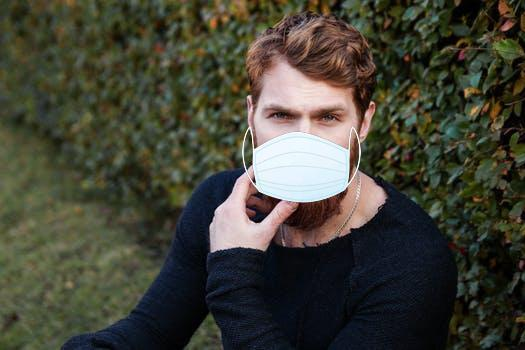

In [5]:
with_mask = list(data_dir.glob('with_mask/*'))
PIL.Image.open(str(with_mask[0]))

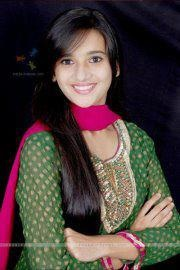

In [6]:
without_mask = list(data_dir.glob('without_mask/*'))
PIL.Image.open(str(without_mask[0]))

In [8]:
batch_size = 10
img_height = 128
img_width = 128

In [9]:
categories=os.listdir('data')
print(categories)

['without_mask', 'with_mask']


In [ ]:
import random
import shutil
def make_train_val(categories,ratio):    
    train_pth='dataset/train'
    val_pth='dataset/validation'
    os.mkdir('dataset')
    os.mkdir(train_pth)
    os.mkdir(val_pth)
    os.mkdir(train_pth+"/"+categories[0])
    os.mkdir(train_pth+"/"+categories[1])
    os.mkdir(val_pth+"/"+categories[1])
    os.mkdir(val_pth+"/"+categories[0])
    with_mask_f=os.listdir('data'+"/"+categories[1])
    without_mask_f=os.listdir('data'+"/"+categories[0])
    with_mask_train=random.sample(with_mask_f,int(ratio*len(with_mask_f)))
    without_mask_train=random.sample(without_mask_f,int((1-ratio)*len(without_mask_f)))
    with_mask_val= list(set(with_mask_f)^set(with_mask_train))
    without_mask_val= list(set(without_mask_f)^set(without_mask_train))
    print(len(with_mask_train),len(with_mask_val))
    for i in with_mask_train:
        shutil.copy('data/with_mask/'+i,train_pth+"/with_mask/")
    for i in without_mask_train:
        shutil.copy('data/without_mask/'+i,train_pth+"/without_mask/")
    for i in with_mask_val:
        shutil.copy('data/with_mask/'+i,val_pth+"/with_mask/")
    for i in without_mask_val:
        shutil.copy('data/without_mask/'+i,val_pth+"/without_mask/")

make_train_val(categories,0.8)    

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')
validation_datagen= ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory('dataset/train',
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='binary')
validation_generator= validation_datagen.flow_from_directory('dataset/validation',
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='binary')

Found 689 images belonging to 2 classes.
Found 687 images belonging to 2 classes.


In [17]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99 % accuracy so cancelling training!")
            self.model.stop_training = True
            
            
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(img_height,img_width,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
from tensorflow.keras.optimizers import RMSprop

history=model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
callbacks=myCallback()
history=model.fit(train_generator,epochs=100,verbose=1,validation_data=validation_generator,callbacks=[callbacks])

Epoch 1/100
69/69 [==============================] - 39s 561ms/step - loss: 0.6227 - acc: 0.7866 - val_loss: 1.3214 - val_acc: 0.2009
Epoch 2/100
69/69 [==============================] - 32s 461ms/step - loss: 0.3082 - acc: 0.8853 - val_loss: 0.7399 - val_acc: 0.6870
Epoch 3/100
69/69 [==============================] - 32s 460ms/step - loss: 0.2672 - acc: 0.9115 - val_loss: 0.4559 - val_acc: 0.8399
Epoch 4/100
69/69 [==============================] - 32s 463ms/step - loss: 0.2323 - acc: 0.9289 - val_loss: 0.3603 - val_acc: 0.8836
Epoch 5/100
69/69 [==============================] - 32s 461ms/step - loss: 0.2249 - acc: 0.9187 - val_loss: 0.2671 - val_acc: 0.9389
Epoch 6/100
69/69 [==============================] - 32s 460ms/step - loss: 0.1791 - acc: 0.9478 - val_loss: 0.2958 - val_acc: 0.8952
Epoch 7/100
69/69 [==============================] - 32s 461ms/step - loss: 0.1698 - acc: 0.9434 - val_loss: 0.1818 - val_acc: 0.9520
Epoch 8/100
69/69 [==============================] - 32s 459ms

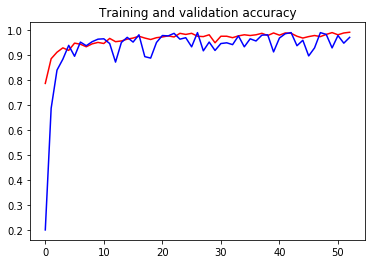

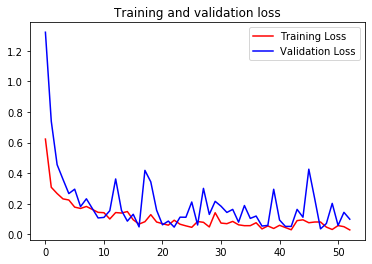

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
#os.mkdir('saved_model')
model.save('saved_model/model_3.h5')

In [ ]:
#Load Model
new_model = tf.keras.models.load_model('saved_model/model_1.h5')

# Check its architecture
new_model.summary()